# Predictive Analytics Technical Specialist- written test


In [83]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from jinja2 import Template
from datetime import datetime,timedelta
import math
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'

chart_width = 1050
chart_height= 500
import covid_overview as covid
# source: https://colab.research.google.com/github/github/covid19-dashboard/blob/master/_notebooks/2020-03-19-cases-and-deaths-per-million.ipynb

In [3]:
# Only consider countries with a Humanitarian Response Plan (HRP) in place .
hpr_countries = ['AFG','BFA','BDI','CMR','CAF','TCD','COD','ETH','HTI','IRQ','LBY','MLI','MMR','NER','NGA','PSE','SOM','SSD','SDN','SYR','UKR','VEN','YEM']

# Input Files

In [4]:
who_file = 'data/un_test/Data_WHO_Coronavirus_Covid-19_Cases_and_Deaths-WHO-COVID-19-global-data.csv'
worldbank_2018_file = 'data/un_test/Worldbank_total_population.xls'
inform_covid19_index_file = 'data/un_test/inform-covid-19-risk-index-v012.xlsx'
shapefile = 'data/un_test/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'

## WHO data

In [5]:
who_df = (pd.read_csv(who_file,parse_dates=[4])
          .query("ISO_3_CODE.isin(@hpr_countries)")
         )
#who_df['date'] = pd.to_datetime(who_df['date_epicrv'])
assert who_df['ISO_3_CODE'].nunique() == len(hpr_countries)

who_df.head(1)

,OBJECTID,ISO_2_CODE,ISO_3_CODE,ADM0_NAME,date_epicrv,NewCase,CumCase,NewDeath,CumDeath,Short_Name_ZH,Short_Name_FR,Short_Name_ES,Short_Name_RU,Short_Name_AR
0,1,AF,AFG,Afghanistan,2020-02-24 00:00:00+00:00,1,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان


## Worldbank data

In [6]:
worldbank_2018_df = pd.read_excel( worldbank_2018_file, sheet_name=0 ,skiprows=[0,1,2])
worldbank_2018_df = worldbank_2018_df.loc[worldbank_2018_df['Country Code'].isin(hpr_countries)]

assert worldbank_2018_df['Country Code'].nunique() == len(hpr_countries)

worldbank_2018_df.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN


## Inform data

In [7]:
inform_covid19_index_df = (pd.read_excel( inform_covid19_index_file, sheet_name='INFORM COVID-19 RISK 2020 (a-z)' ,skiprows=[0,2] )
                           .query("ISO3.isin(@hpr_countries)")
                          )
assert inform_covid19_index_df['ISO3'].nunique() == len(hpr_countries)

inform_covid19_index_df.head(1)

,COUNTRY,ISO3,P2P,COVID-19 HAZARD & EXPOSURE,Development & Deprivation,Inequality,Aid Dependency,Socio-Economic Vulnerability,Uprooted people,Health Conditions,...,Infrastructure,LACK OF COPING CAPACITY (Hazard-independent),COVID-19 LACK OF COPING CAPACITY,LACK OF COPING CAPACITY,INFORM COVID-19 RISK,COVID-19 RISK CLASS,Rank,Lack of Reliability (*),Number of Missing Indicators,% of Missing Indicators
0,Afghanistan,AFG,6.4,6.4,8.6,7.7,6.8,7.9,9.7,2.1,...,8.3,8.3,7,7.7,6.8,Very High,5.0,NaN,NaN,NaN


# Question 1

Using the WHO dataset as of 30 April please answer the following questions. Only consider
countries with a Humanitarian Response Plan (HRP) in place

## Sub-Question 1
What are the top 3 countries where we are observing the largest absolute number of
cases (cumulative)?

In [8]:
who_df_g = who_df.groupby(['ISO_3_CODE'])
q1_res_df =who_df_g.tail(1)[['ADM0_NAME','ISO_3_CODE','CumCase','CumDeath']].sort_values(by='CumCase',ascending=[False])

In [9]:
print(f"Question1: The three countries with the absolute largest number of cases are: {list(q1_res_df[['ADM0_NAME','CumCase']].head(3).itertuples(index=False, name=None))}.")

Question1: The three countries with the absolute largest number of cases are: [('Ukraine', 10406), ('Iraq', 2003), ('Afghanistan', 1827)].


## Sub-Question 2
How does this list change if you look at the total number of cases relative to the
country’s population (i.e. number of cases per capita)? Please use the 2018 World Bank
population from the “Total Population” file on HDX.


In [10]:
q2_merged_df = q1_res_df.merge(worldbank_2018_df[['2018', 'Country Code']], how='left', left_on='ISO_3_CODE', right_on='Country Code')

In [11]:
q2_merged_df['2018'] = q2_merged_df['2018'].astype(int)
q2_merged_df['CumCase_rel'] = q2_merged_df['CumCase'] / q2_merged_df['2018'] * 100000

In [12]:
q2_res_df = q2_merged_df.sort_values(by='CumCase_rel',ascending=[False])
q2_res_df.head(1)

,ADM0_NAME,ISO_3_CODE,CumCase,CumDeath,2018,Country Code,CumCase_rel
0,Ukraine,UKR,10406,261,44622516,UKR,23.320066


In [13]:
print(f"Question 2: The three countries with the highest number of cases per 100000 are: {list(q2_res_df[['ADM0_NAME','CumCase_rel']].head(3).itertuples(index=False, name=None))}.")

Question 2: The three countries with the highest number of cases per 100000 are: [('Ukraine', 23.320065591998443), ('occupied Palestinian territory', 7.528856421425111), ('Cameroon', 7.162051974685992)].


## Sub-Question 3
Provide an estimate of overall Case Fatality Ratio - CFR - for these countries. What are
the 3 countries with the highest CFR?

CRF = Proportion of death from all infected

In [14]:
q3_df = q1_res_df.copy()

In [15]:
q3_df['cfr'] = q3_df['CumDeath'] * 100 / q3_df['CumCase']

In [16]:
q3_res_df = q3_df.sort_values(by=['cfr'], ascending=False)

In [17]:
print(f"Question 3: The three countries with the highest CFR are: {list(q3_res_df[['ADM0_NAME','cfr']].head(3).itertuples(index=False, name=None))}.")

Question 3: The three countries with the highest CFR are: [('Haiti', 7.894736842105263), ('Sudan', 7.466666666666667), ('Syrian Arab Republic', 6.976744186046512)].


## Sub-Question 4

Using this shapefile from Natural Earth, draw a simple heatmap of the CFR.

In [20]:
# source: https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

import geopandas as gpd
#shapefile = 'data/countries_110m/ne_110m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head(1)


,country,country_code,geometry
0,Indonesia,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."


In [21]:
merged = gdf.merge(q3_df, how='left',left_on = 'country_code', right_on = 'ISO_3_CODE')

In [22]:
import json
#Read data to json.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [ ]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = max(q3_df.cfr))
#Define custom tick labels for color bar.
#tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')
#, major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Case fatality ratio for COVID-19 pandemic in countries with a Humanitarian Response Plan', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'cfr', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
#show(p)

## Sub-Question 5

Using the INFORM COVID-19 Risk Index Version 0.1.2 identify whether in these countries the scale of the outbreak (i.e. number of cases per capita) is mainly driven by the following factors in INFORM:
* COVID-19 HAZARD & EXPOSURE
* COVID-19 VULNERABILITY
* COVID-19 LACK OF COPING CAPACITY

In [25]:
# source: https://github.com/CrazyDaffodils/Interactive-Choropleth-Map-Using-Python/blob/master/bokeh-app/coronavirus_geocode_csv.ipynb
import xgboost
import shap
shap.initjs()

cols_for_analysis = ['ISO3','COVID-19 HAZARD & EXPOSURE','COVID-19 VULNERABILITY','COVID-19 LACK OF COPING CAPACITY']

In [26]:
q5_merged = (inform_covid19_index_df[cols_for_analysis]
             .merge(q2_res_df, how='left', left_on='ISO3', right_on='ISO_3_CODE')
             .drop(['ISO_3_CODE','Country Code', 'CumCase', '2018'], axis=1)
            ) 
q5_merged['COVID-19 HAZARD & EXPOSURE'] = q5_merged['COVID-19 HAZARD & EXPOSURE'].astype(float)
q5_merged['COVID-19 VULNERABILITY'] = q5_merged['COVID-19 VULNERABILITY'].astype(float)
q5_merged['COVID-19 LACK OF COPING CAPACITY'] = q5_merged['COVID-19 LACK OF COPING CAPACITY'].astype(float)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


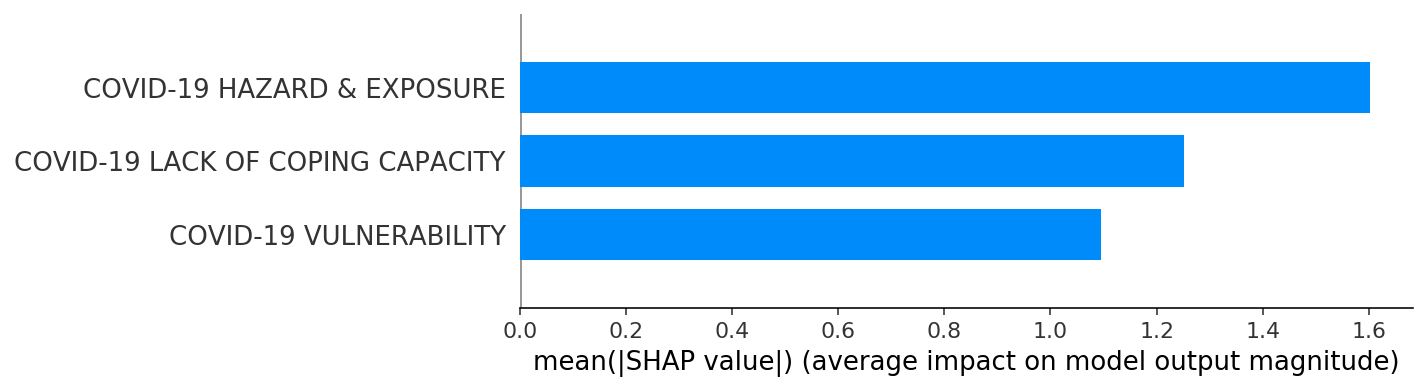

In [27]:
# train XGBoost model
X,y = (q5_merged[['COVID-19 HAZARD & EXPOSURE','COVID-19 VULNERABILITY','COVID-19 LACK OF COPING CAPACITY']],np.log(q5_merged['CumCase_rel'].tolist()))
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 400)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(np.exp(shap_values), X, plot_type="bar")

In [226]:
q5_merged.head()

,ISO3,COVID-19 HAZARD & EXPOSURE,COVID-19 VULNERABILITY,COVID-19 LACK OF COPING CAPACITY,ADM0_NAME,CumDeath,CumCase_rel
0,AFG,6.4,3.5,7.00,Afghanistan,60,4.914939
1,BFA,7.7,2.5,7.30,Burkina Faso,42,3.230129
2,BDI,6.8,2.8,7.60,Burundi,1,0.134224
3,CMR,6.4,2.4,5.60,Cameroon,59,7.162052
4,CAF,6.5,2.8,9.35,Central African Republic,0,1.071495


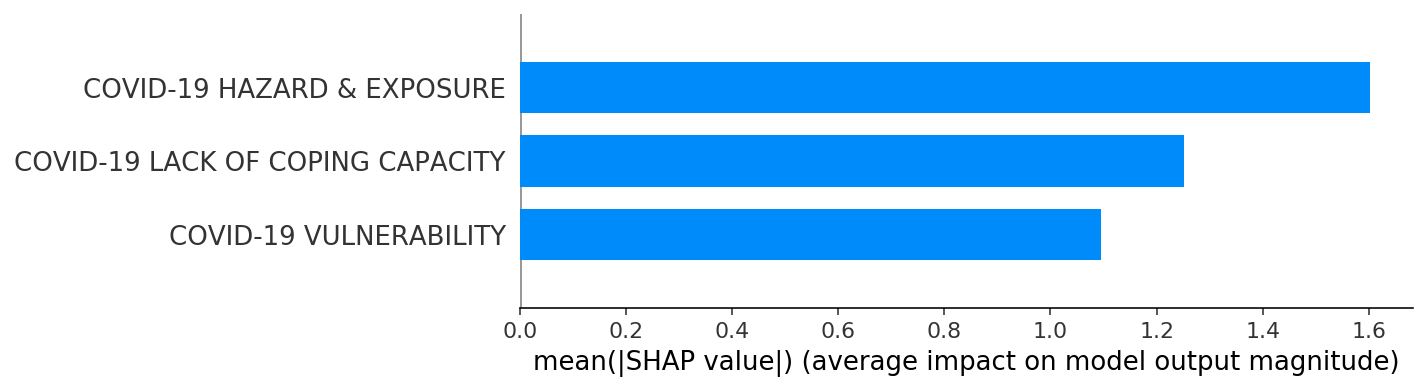

In [28]:
X,y = (q5_merged[['COVID-19 HAZARD & EXPOSURE','COVID-19 VULNERABILITY','COVID-19 LACK OF COPING CAPACITY']],np.log(q5_merged['CumCase_rel'].tolist()))
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 400)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(np.exp(shap_values), X, plot_type="bar")

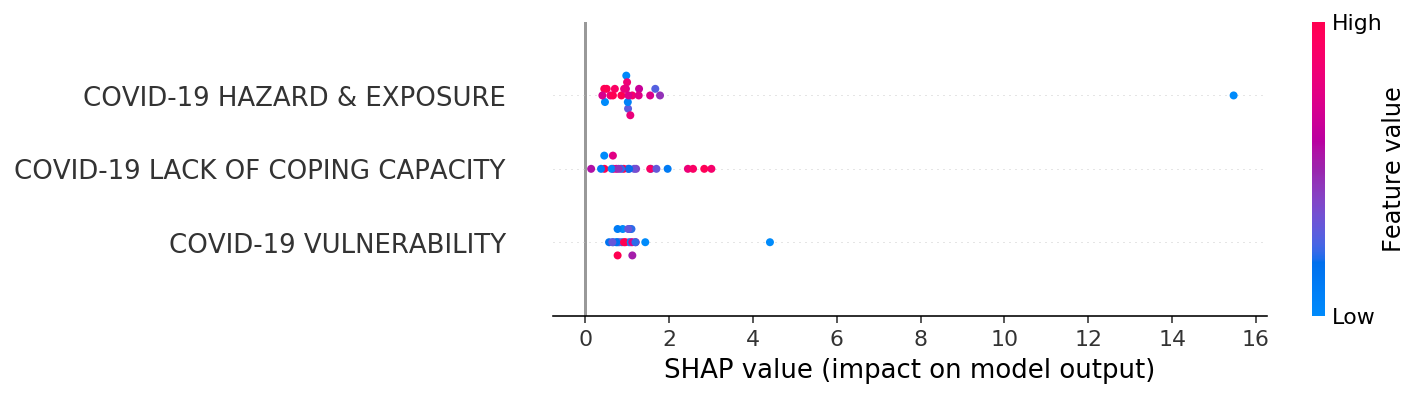

In [29]:
shap.summary_plot(np.exp(shap_values), X)

In [34]:
print(f"Question 5: I calculated SHAP values for the three features. The contribution of the features to the outcomeis in this order: 'COVID-19 HAZARD & EXPOSURE' (1.61),'COVID-19 VULNERABILITY' (1.22 SHAP value),'COVID-19 LACK OF COPING CAPACITY (1.1)' ")

Question 5: I calculated shapley values for the three features. The contribution of the features is in this order: 'COVID-19 HAZARD & EXPOSURE' (1.61),'COVID-19 VULNERABILITY' (1.22 SHAP value),'COVID-19 LACK OF COPING CAPACITY (1.1)' 


### Sub-Question 5 (alternative)

If the idea was to look the overall picture of feature contributions to the result, then I would do it in the following way:

In [68]:
q5_merged = (inform_covid19_index_df.drop(['COUNTRY','P2P','Lack of Reliability (*)','Number of Missing Indicators','% of Missing Indicators'], axis=1)
             .merge(q2_res_df, how='left', left_on='ISO3', right_on='ISO_3_CODE')
             .drop(['ISO_3_CODE','Country Code', 'CumCase', '2018'], axis=1)
            ) 
q5_merged['COVID-19 HAZARD & EXPOSURE'] = q5_merged['COVID-19 HAZARD & EXPOSURE'].astype(float)
q5_merged['COVID-19 VULNERABILITY'] = q5_merged['COVID-19 VULNERABILITY'].astype(float)
q5_merged['COVID-19 LACK OF COPING CAPACITY'] = q5_merged['COVID-19 LACK OF COPING CAPACITY'].astype(float)
#q5_merged['Inequality'] = q5_merged['Inequality'].astype(float)

#q5_merged['Inequality'] = q5_merged['Inequality'].str.replace('x',np.nan)
#q5_merged['Inequality'].fillna((q5_merged['Inequality'].mean()), inplace=True)

q5_merged['Health Conditions'] = q5_merged['Health Conditions'].astype(float)
#q5_merged['GBV'] = q5_merged['GBV'].astype(float)
q5_merged['Demographic and co-morbidity'] = q5_merged['Demographic and co-morbidity'].astype(float)

q5_merged['Access to health care'] = q5_merged['Access to health care'].astype(float)
q5_merged['Infrastructure'] = q5_merged['Infrastructure'].astype(float)

q5_merged['COVID-19 RISK CLASS'] = pd.factorize(q5_merged['COVID-19 RISK CLASS'], sort=True)[0] + 1 


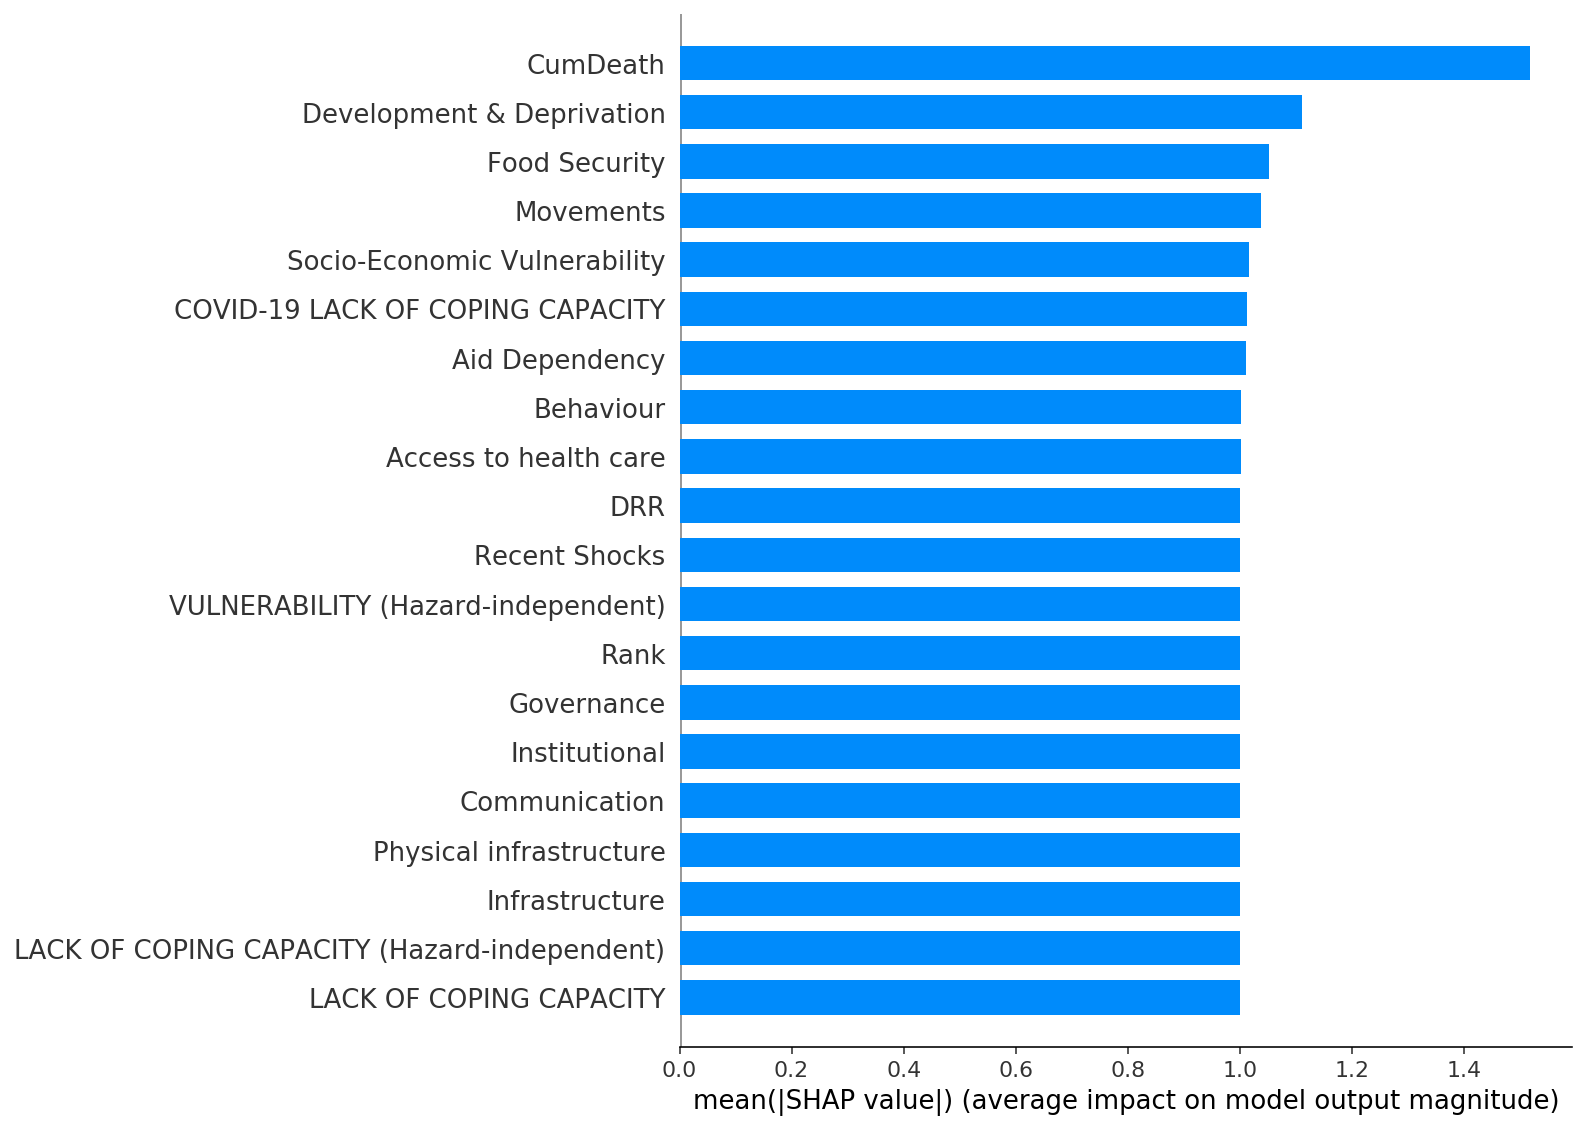

In [70]:
X,y = (q5_merged.drop(['ISO3','ADM0_NAME','Inequality','GBV','CumCase_rel'], axis=1),np.log(q5_merged['CumCase_rel'].tolist()))
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 400)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(np.exp(shap_values), X, plot_type="bar")

In [75]:
print(f"Question 5 (alt): When I understand the question as : How much is the contribution of the three mentioned features compared to other features, I get that features like 'Development&Deprivation', 'Food Security', and 'Movements' have a bigger influence on the output.")

Question 5 (alt): When I understand the question as : How much is the contribution of the three mentioned features compared to other features, I get that features like 'Development&Deprivation', 'Food Security', and 'Movements' have a bigger influence on the output.


In [76]:
# todo: If time: https://github.com/delunapaolo/tree-explainer/tree/master/notebooks

## Sub-Question 6

Assuming an exponential trend in the total number of cases in Afghanistan (ISO3 code ‘AFG’), give an estimate of the doubling time.


In [84]:
#source: https://www.mathebibel.de/verdopplungszeit
q6_subset_df = who_df.query('ISO_3_CODE == "AFG"')
q6_subset_df.head(2)

,OBJECTID,ISO_2_CODE,ISO_3_CODE,ADM0_NAME,date_epicrv,NewCase,CumCase,NewDeath,CumDeath,Short_Name_ZH,Short_Name_FR,Short_Name_ES,Short_Name_RU,Short_Name_AR
0,1,AF,AFG,Afghanistan,2020-02-24 00:00:00+00:00,1,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان
1,2,AF,AFG,Afghanistan,2020-02-25 00:00:00+00:00,0,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان


In [ ]:
# get days since first occurrence of infection

first_date = pd.Timestamp('2020-02-24', tz='UTC')
date = q6_subset_df['date_epicrv']
q6_subset_df['days'] = date.map(lambda x : (x - first_date).days  )

## calculate average growth rate
for i in range(1, len(q6_subset_df)):
    q6_subset_df.loc[i, 'growth_rate'] = (q6_subset_df.loc[i, 'CumCase'] - q6_subset_df.loc[i-1, 'CumCase']) / q6_subset_df.loc[i, 'CumCase']

In [86]:
mean_growth_rate = 1+ np.mean(q6_subset_df['growth_rate'])
estimated_doubling_time = math.log(2)/math.log(mean_growth_rate)


In [88]:
print(f"Question 6: The estimated doubling time is ~ {round(estimated_doubling_time, 2)} days.")

Question 6: The estimated doubling time is ~ 7.82 days.


# Question 2

Imagine that you are responding to a request from the OCHA country office in Nigeria for a
COVID-19 model to support the COVID-19 Humanitarian Response Plan. The country office is
interested in understanding where they should preposition resources, what are the key areas
and groups that are expected to be most impacted and what are the most successful
non-pharmaceutical interventions that can be implemented in Nigeria.
After reviewing the COVID-19 models available, the Predictive Analytics team has decided to
adapt a model initially developed by the Imperial College of London for the UK and the US to the
Nigerian context.

Please describe how you would plan this analysis and what are the key issues and main
challenges that you expect to face. Identify:

## Sub-Question 1

Who are the main stakeholders you need to engage with,

Question 1:

The main stakeholders are 
* OCHA contry office, ideally a focal point as main point of contact for coordination
* Authorities in Nigeria:
    * Ministry of health with their newly setup advisory committe on COVIC-19 as well as the response task force
* Due to the ongoing conflict in the North-East of Nigera, stakeholders of the regions of Borno, Adamawa and Yobe (e.g. Nigerian Army, the Department of State Security Services, the Nigerian Human Rights Commission, as well as the Nigerian Emergency Management Agency, National Commission for Refugees, Migrants and IDPs and the members of the National IHL Committee
* NGOs that deliver care and have access to vulnerable/risk groups, including in remote areas
* International organisations such as WHO, committee of the red cross as well as the Nigerian red cross
* The humanitarian data center team to agree on an engagement strategy as well as to learn from potentially previously implemented models in other HPR countries.
* The authors at the Imperial College of London to understand how and why they made adjustments to their model and to get feedback on our own plan to modify their model to work in the Nigerian context.
    

## Sub-Question 2

What are the main modifications to the Imperial model that need to be made to make the
model reliable in the Nigerian context

Question 2:

The model needs to be modified in the following areas to model to particularities of Nigera.
Examples of differences are: People in Nigeria are on average 27 years younger, 3.1 times less obese, ~50% less likely to have access to improved drinking water, 3.7 times less likely to have internet access. These factors might be relevant for chosen model parameters as well as final delivery of services and implementation of measures.

Besides adjusting for the differences in population characteristics (density, age, livelihood, etc.), the model should take into account the following features that are prominent in Nigeria:
    
* Current stressors on the health system, e.g. potential outbreaks/occurrences of other infectious disease, vaccination campaigns.
* Access to health services/ health insurance.
* High-risk areas with conflicts.
* High-risk populations in refugee camps.
* Populations in remote areas that are difficult to reach.
* Differences in expenditures on health care. 
* Potential difficulties in accessing food and water in addition to health crisis.


## Sub-Question 3

What are the main datasets needed to develop this model,

Question 3:
    
Most of the dataset to develop this model can be found on HDX.
The main areas of dataset are:
* Census data on population distribution as well as age/gender/disabilities/livelihood to calculate 
* Data on vulnerable/risk groups, e.g. data of ongoing conflict, internally displaced people   
* Data on health, including health site mappings, health indicators
* Data on aid effectiveness or other humanitarian aid initiatives in the region where coordination is required

## Sub-Question 4

How would you ensure that the model is relevant for the country office and can be used
effectively to inform the COVID-19 response.

Question 4:

* Kick-off meeting with responsible stakeholders to perform a needs analysis 
* Check with colleagues with experience in either developing similar models or working with authorities in Nigeria.
* Present model results in a way easy to understand e.g. build a COVID-19 dashboard showcasing the model's main findings and recommendation or generate a fact sheet that can be given to local authorities and health care professionals.
* Present the models results in form of recommendations for prioritities in implementation of measures.
* Integration of new data as they become available in order to provide the most up-to-date view/ findings of the Corona pandemic and thereby the best possible response recommendations.
* Monitor and evaluate if the findings and recommendations are understood and have an effect by actively seeking feedback. Adjust the model if necessary
* Set up a database of relevant information from various sources covering recommendations for different areas of COVID-19 response, e.g. gender,children, risk groups (elderly, pregnant women, other diseases), IDPs, trafficking